In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import json
import zipfile
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary
import pickle
import textwrap
import random

import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load Questions
def load_questions(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    questions = {q["question_id"]: {"image_id": q["image_id"], "question": q["question"]} for q in data["questions"]}
    return questions

# Load Annotations
def load_annotations(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    annotations = {}
    for ann in data["annotations"]:
        question_id = ann["question_id"]
        annotations[question_id] = {
            "answer": ann["multiple_choice_answer"],
            "answer_type": ann["answer_type"],
            "question_type": ann["question_type"]
        }
    return annotations

# Paths to JSON files
train_questions_path = "/kaggle/input/visual-based-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json"
val_questions_path = "/kaggle/input/visual-based-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json"
train_annotations_path = "/kaggle/input/visual-based-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json"
val_annotations_path = "/kaggle/input/visual-based-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json"

# Load data
train_questions = load_questions(train_questions_path)
val_questions = load_questions(val_questions_path)
train_annotations = load_annotations(train_annotations_path)
val_annotations = load_annotations(val_annotations_path)

In [4]:
# Merge Questions and Annotations
def merge_data(questions, annotations):
    merged_data = []
    for qid, q_data in questions.items():
        if qid in annotations:
            merged_data.append({**q_data, **annotations[qid]})
    return merged_data

train_data = merge_data(train_questions, train_annotations)
val_data = merge_data(val_questions, val_annotations)

# Convert to DataFrame
# Sample 100k from train_data
train_df = pd.DataFrame(train_data)

# Sample 50k from val_data
temp_df = pd.DataFrame(val_data)

print(f"train size: {len(train_df)}")
print(f"val size: {len(temp_df)}")

train size: 443757
val size: 214354


In [5]:
def save_vocab(vocab, file_path='vocab.pkl'):
    with open(file_path, 'wb') as f:
        pickle.dump(vocab, f)
def load_vocab(file_path='vocab.pkl'):
    with open(file_path, 'rb') as f:
        vocab = pickle.load(f)
    return vocab

In [6]:
#  Build Vocabulary
def build_vocab(data, answer_vocab_size=2000, answer_min_freq=1):
    word_freq = Counter()
    answer_freq = Counter(data['answer'])

    # Tokenize and count word frequency in questions
    for q in data['question']:
        word_freq.update(word_tokenize(q.lower()))

    word2idx = {word: idx+1 for idx, (word, _) in enumerate(word_freq.most_common())}
    word2idx['<PAD>'] = 0
    word2idx['<UNK>'] = len(word2idx)  # For unseen words

    # Filter answers based on min frequency
    filtered_answers = {ans: freq for ans, freq in answer_freq.items() if freq >= answer_min_freq}

    # Keep top K answers
    most_common_answers = sorted(filtered_answers.items(), key=lambda x: x[1], reverse=True)[:answer_vocab_size]
    answer2idx = {ans: idx for idx, (ans, _) in enumerate(most_common_answers)}
    answer2idx['<UNK>'] = len(answer2idx)  # Assign unseen answers to <UNK_ANS>

    idx2word = {v: k for k, v in word2idx.items()}
    idx2answer = {v: k for k, v in answer2idx.items()}

    return {
        'word2idx': word2idx,
        'idx2word': idx2word,
        'answer2idx': answer2idx,
        'idx2answer': idx2answer
    }



def collate_fn(batch):
    images, questions, answers = zip(*batch)

    # Convert lists to tensors
    images = torch.stack(images, dim=0) 

    # Pad questions to the same length
    questions = pad_sequence(questions, batch_first=True, padding_value=0)

    # Convert answers to tensor
    answers = torch.tensor(answers)

    return images, questions, answers

In [7]:
class VQADataset(Dataset):
    def __init__(self, data, image_folder, vocab=None, transform=None, max_q_len=20):
        self.data = data
        self.image_folder = image_folder
        self.transform = transform
        self.max_q_len = max_q_len
        self.vocab = vocab 

    def encode_question(self, question):
        tokens = word_tokenize(question.lower())
        encoded = [self.vocab['word2idx'].get(word, self.vocab['word2idx']['<UNK>']) for word in tokens]
        return encoded + [0] * (self.max_q_len - len(encoded))  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Get image path
        if "train" in self.image_folder.lower():
            img_path = f"{self.image_folder}/COCO_train2014_{int(row['image_id']):012d}.jpg"
        else:
            img_path = f"{self.image_folder}/COCO_val2014_{int(row['image_id']):012d}.jpg"

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        question = self.encode_question(row['question'])

        # Fix: Use <UNK_ANS> for unknown answers
        answer = self.vocab['answer2idx'].get(row['answer'], self.vocab['answer2idx']['<UNK>'])

        return torch.tensor(image), torch.tensor(question), torch.tensor(answer)


In [8]:
# Load CSV
df = pd.concat([train_df, temp_df], ignore_index=True)

# Build vocabulary once from the entire dataset
vocab = build_vocab(df,5000)
save_vocab(vocab, 'vocab.pkl')
#  Stratified Split (assuming 'question_type' column exists)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=101)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_folder="/kaggle/input/visual-based-question-answering/train2014/train2014"
val_folder="/kaggle/input/visual-based-question-answering/val2014/val2014"

train_dataset = VQADataset(train_df, image_folder=train_folder, 
                           vocab=vocab, transform=transform)
val_dataset = VQADataset(val_df, image_folder=val_folder, 
                         vocab=vocab, transform=transform)
test_dataset = VQADataset(test_df, image_folder=val_folder, 
                          vocab=vocab, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)


In [10]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Remove the classification head
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])

        # Adaptive pooling to retain spatial info
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        # Fully connected layers for gradual dimensionality reduction
        self.fc_image = nn.Sequential(
            nn.Linear(2048 * 2 * 2, 4096),  
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(4096, 2048),  
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(2048, 1024),  
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # Freeze early layers for fine-tuning
        for param in list(self.cnn.parameters())[:-10]:  
            param.requires_grad = False

    def forward(self, images):
        img_features = self.cnn(images)             
        img_features = self.avgpool(img_features)   
        img_features = torch.flatten(img_features, start_dim=1)
        img_features = self.fc_image(img_features)
        return img_features



class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512):
        super(QuestionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
            
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, num_layers=3, bidirectional=True,dropout=0.3)

        self.fc_q = nn.Sequential(
            nn.Linear(2 * hidden_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, questions):
        q_embed = self.embedding(questions)
        
        _, (q_hidden, _) = self.lstm(q_embed)

        # Reshape and concatenate the last forward and backward hidden states
        q_hidden = q_hidden.view(self.lstm.num_layers, 2, q_hidden.size(1), q_hidden.size(2))[-1]
        q_hidden = torch.cat((q_hidden[0], q_hidden[1]), dim=1)

        q_hidden = self.fc_q(q_hidden)
        return q_hidden


class VQAModel(nn.Module):
    def __init__(self, vocab_size, ans_vocab_size, embed_dim=512, hidden_dim=512):
        super(VQAModel, self).__init__()
        self.image_encoder = ImageEncoder()
        self.question_encoder = QuestionEncoder(vocab_size, embed_dim, hidden_dim)

        # Fusion and Classification Layers
        self.fc_combined = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fc_final = nn.Linear(1024, ans_vocab_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, images, questions):
        img_features = self.image_encoder(images)
        q_features = self.question_encoder(questions)

        # Fusion
        combined = torch.cat((img_features, q_features), dim=1)
        combined = self.fc_combined(combined)

        # Predict Answer
        output = self.fc_final(combined)
        return output

In [9]:
# Define model
vocab_size = len(train_dataset.vocab['word2idx'])
ans_vocab_size = len(train_dataset.vocab['answer2idx'])
model = VQAModel(vocab_size, ans_vocab_size)
model.to("cpu")  

# Create sample input data
image = torch.randn(20, 3, 224, 224)  
question = torch.randint(0, vocab_size, (20, 10), dtype=torch.long)  

# Run a forward pass
output = model(image, question)
summary(model, input_data=[image, question], device="cpu")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
VQAModel                                           [20, 5001]                --
├─ImageEncoder: 1-1                                [20, 1024]                --
│    └─Sequential: 2-1                             [20, 2048, 7, 7]          --
│    │    └─Conv2d: 3-1                            [20, 64, 112, 112]        (9,408)
│    │    └─BatchNorm2d: 3-2                       [20, 64, 112, 112]        (128)
│    │    └─ReLU: 3-3                              [20, 64, 112, 112]        --
│    │    └─MaxPool2d: 3-4                         [20, 64, 56, 56]          --
│    │    └─Sequential: 3-5                        [20, 256, 56, 56]         (215,808)
│    │    └─Sequential: 3-6                        [20, 512, 28, 28]         (1,219,584)
│    │    └─Sequential: 3-7                        [20, 1024, 14, 14]        (7,098,368)
│    │    └─Sequential: 3-8                        [20, 2048, 7, 7]          14,96

In [10]:
def train_loop(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, questions, answers in tqdm(train_loader, desc="Training", leave=False):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, answers)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == answers).sum().item()
        total_samples += answers.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

#  Define Validation Loop
def val_loop(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, questions, answers in tqdm(val_loader, desc="Validating", leave=False):
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)

            outputs = model(images, questions)
            loss = criterion(outputs, answers)

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == answers).sum().item()
            total_samples += answers.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

In [11]:
# Initialize model
vocab_size = len(train_dataset.vocab['word2idx'])
ans_vocab_size = len(train_dataset.vocab['answer2idx'])
model = VQAModel(vocab_size, ans_vocab_size).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.2)

In [ ]:
num_epochs = 50
save_every = 10  
patience = 7  



train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float("inf")
early_stop_counter = 0

#  Training Loop
for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_loop(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = val_loop(model, val_loader, criterion, device)

    #  Store Metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    #  Learning Rate Scheduler Step
    scheduler.step(val_loss)

    #  Save Model Every 4 Epochs
    if (epoch + 1) % save_every == 0:
        torch.save(model, f"model_epoch_{epoch+1}.pth")
        print(f" Model saved at epoch {epoch+1}!")

    #  Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, "best_model.pth")
        print(" best model saved!")
        early_stop_counter = 0 
    else:
        early_stop_counter += 1 

    if early_stop_counter >= patience:
        print("⏹ Early stopping triggered! Training stopped.")
        break

print(" Training complete! ")


🔹 Epoch 1/50


📊 Train Loss: 3.1989 | Train Acc: 0.3302
📊 Val Loss: 2.6108 | Val Acc: 0.3819
💾 best model saved!

🔹 Epoch 2/50


📊 Train Loss: 2.4069 | Train Acc: 0.3955
📊 Val Loss: 2.2975 | Val Acc: 0.4084
💾 best model saved!

🔹 Epoch 3/50


📊 Train Loss: 2.1123 | Train Acc: 0.4307
📊 Val Loss: 2.1553 | Val Acc: 0.4219
💾 best model saved!

🔹 Epoch 4/50


📊 Train Loss: 1.9245 | Train Acc: 0.4585
📊 Val Loss: 2.0919 | Val Acc: 0.4294
💾 best model saved!

🔹 Epoch 5/50


📊 Train Loss: 1.7770 | Train Acc: 0.4834
📊 Val Loss: 2.0694 | Val Acc: 0.4303
💾 best model saved!

🔹 Epoch 6/50


📊 Train Loss: 1.6528 | Train Acc: 0.5069
📊 Val Loss: 2.0700 | Val Acc: 0.4319

🔹 Epoch 7/50


📊 Train Loss: 1.5406 | Train Acc: 0.5305
📊 Val Loss: 2.0835 | Val Acc: 0.4326

🔹 Epoch 8/50


📊 Train Loss: 1.4377 | Train Acc: 0.5547
📊 Val Loss: 2.1009 | Val Acc: 0.4310

🔹 Epoch 9/50


📊 Train Loss: 1.2412 | Train Acc: 0.6089
📊 Val Loss: 2.1307 | Val Acc: 0.4307

🔹 Epoch 10/50


📊 Train Loss: 1.1816 | Train Acc: 0.6248
📊 Val Loss: 2.1594 | Val Acc: 0.4275
💾 Model saved at epoch 10!

🔹 Epoch 11/50


📊 Train Loss: 1.1432 | Train Acc: 0.6353
📊 Val Loss: 2.1903 | Val Acc: 0.4273

🔹 Epoch 12/50


📊 Train Loss: 1.0846 | Train Acc: 0.6535
📊 Val Loss: 2.1936 | Val Acc: 0.4265
⏹️ Early stopping triggered! Training stopped.
🎉 Training complete! 🚀


In [13]:
# Store results for later analysis
training_metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies
}

# Save training metrics to a file
with open("training_metrics.pkl", "wb") as f:
    pickle.dump(training_metrics, f)
print(" Training metrics saved!")

📊 Training metrics saved!


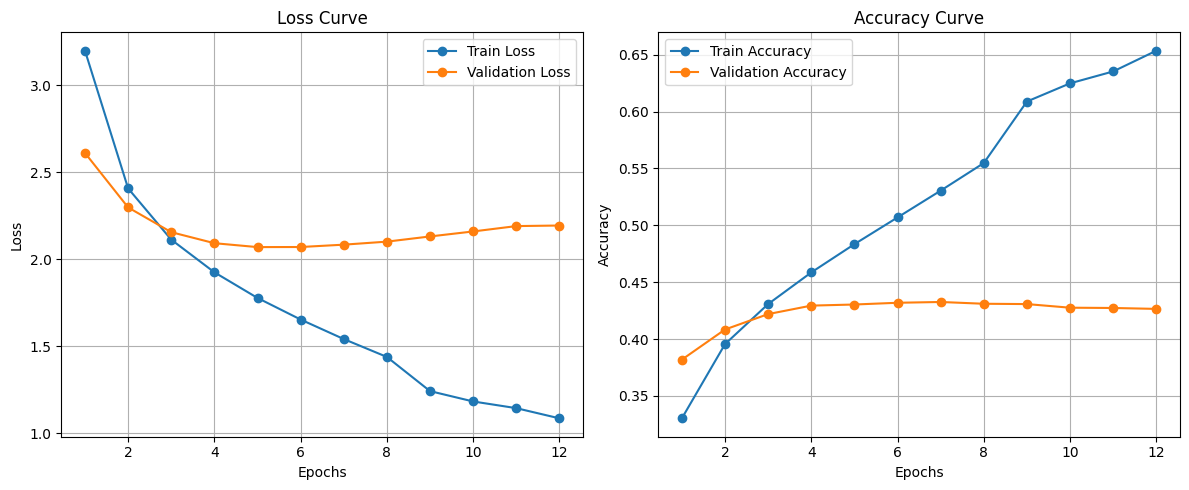

In [14]:
epochs = range(1, len(train_losses) + 1)

#  Plot Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()

#  Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [15]:
model.eval()

# Store predictions & actual labels by category
category_results = {}
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch_idx, (images, questions, answers) in enumerate(test_loader):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        # Model prediction
        outputs = model(images, questions)
        predicted_answers = outputs.argmax(dim=1)  

        # **Batch-wise answer types & true labels**
        batch_answer_types = test_dataset.data.iloc[
            batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size
        ]["answer_type"].tolist()
        batch_true_answers = test_dataset.data.iloc[
            batch_idx * test_loader.batch_size : (batch_idx + 1) * test_loader.batch_size
        ]["answer"].tolist()

        # Iterate over batch
        for idx in range(len(images)):  
            a_type = batch_answer_types[idx] 
            true_ans = batch_true_answers[idx] 
            pred_ans = test_dataset.vocab["idx2answer"][predicted_answers[idx].item()] 

            # Store results per category
            if a_type not in category_results:
                category_results[a_type] = {"correct": 0, "total": 0}

            category_results[a_type]["total"] += 1
            total_samples += 1  

            if true_ans == pred_ans:
                category_results[a_type]["correct"] += 1
                total_correct += 1  

#  Print Category-wise Accuracy
print("\n **Category-wise Accuracy:**")
print("=" * 50)
for a_type, data in category_results.items():
    acc = (data["correct"] / data["total"]) * 100
    print(f" **Answer Type:** {a_type}")
    print(f" Accuracy: {acc:.2f}% ({data['correct']}/{data['total']})")
    print("-" * 50)

#  Compute & Print Overall Accuracy
overall_accuracy = (total_correct / total_samples) * 100
print("\n **Overall Accuracy:**")
print("=" * 50)
print(f" **Total Accuracy:** {overall_accuracy:.2f}% ({total_correct}/{total_samples})")
print("=" * 50)



📊 **Category-wise Accuracy:**
 **Answer Type:** other
✅ Accuracy: 31.74% (16826/53011)
--------------------------------------------------
 **Answer Type:** yes/no
✅ Accuracy: 55.64% (22279/40038)
--------------------------------------------------
 **Answer Type:** number
✅ Accuracy: 24.74% (3495/14128)
--------------------------------------------------

🌟 **Overall Accuracy:**
✅ **Total Accuracy:** 39.75% (42600/107177)


In [ ]:
model=torch.load("/kaggle/input/models/best_model.pth")
model.to(device)
vocab = load_vocab('vocab.pkl')

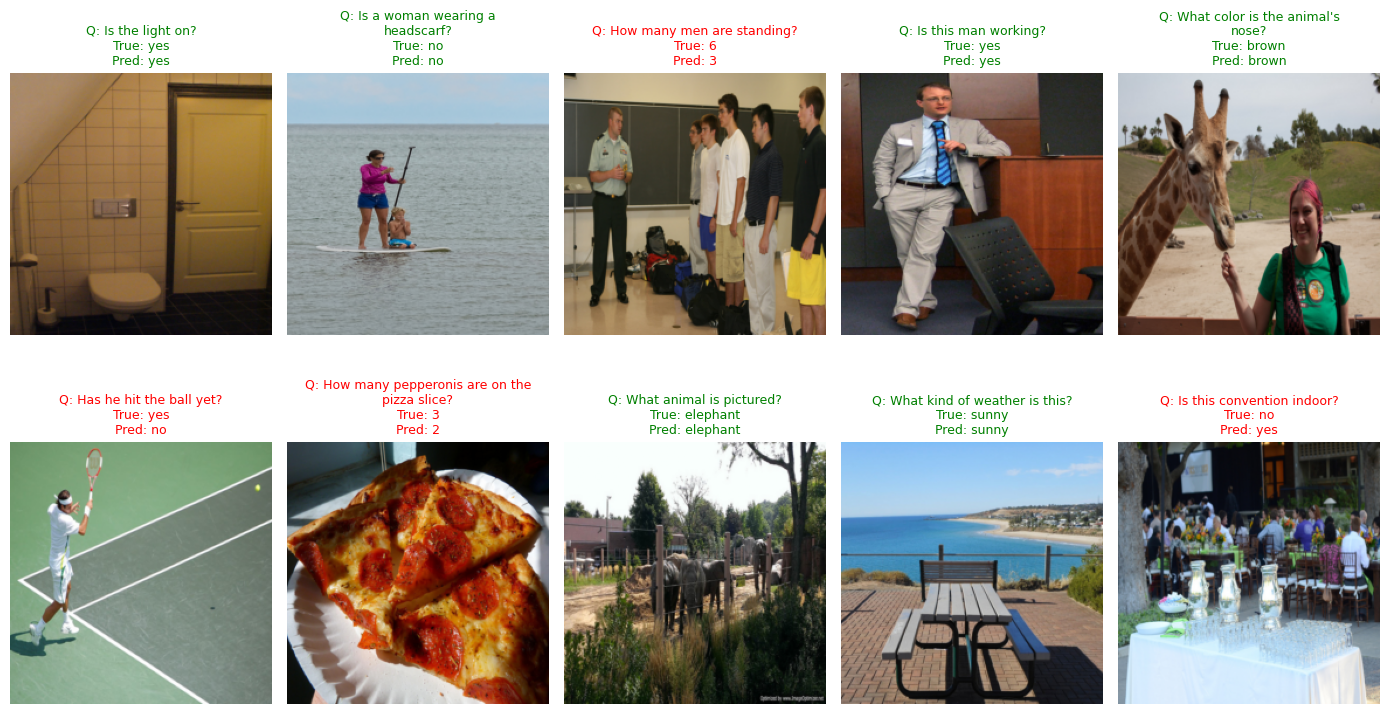

In [15]:
# ImageNet mean and std for denormalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)  
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)  
random.seed(101)
model.eval()

# Select 10 random samples from test_df
num_samples = 10
random_indices = random.sample(range(len(test_df)), num_samples)  
selected_data = test_df.iloc[random_indices]  

# Prepare tensors for model input
images, questions,question_texts, true_answers = [], [], [], []

for _, row in selected_data.iterrows():
    # Load and transform image
    if "train" in test_dataset.image_folder.lower():
        img_path = f"{test_dataset.image_folder}/COCO_train2014_{int(row['image_id']):012d}.jpg"
    else:
        img_path = f"{test_dataset.image_folder}/COCO_val2014_{int(row['image_id']):012d}.jpg"

    image = Image.open(img_path).convert('RGB')
    if test_dataset.transform:
        image = test_dataset.transform(image)
    
    # Encode question
    encoded_question = test_dataset.encode_question(row['question'])

    # Get true answer
    question_texts.append(row['question'])
    true_answer = row["answer"]

    images.append(image)
    questions.append(torch.tensor(encoded_question))
    true_answers.append(true_answer)

# Convert lists to tensors
images = torch.stack(images).to(device)
questions = torch.stack(questions).to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images, questions)
    predicted_answers_idx = outputs.argmax(dim=1)

# Plot setup (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(14, 8))

for idx in range(num_samples):
    row, col = divmod(idx, 5)  

    # Convert predicted answer index to text
    pred_answer = test_dataset.vocab['idx2answer'].get(predicted_answers_idx[idx].item(), "Unknown Answer")

    # Wrap question text for better readability
    wrapped_question = "\n".join(textwrap.wrap(question_texts[idx], width=30))

    # Denormalize the image
    img_denorm = images[idx].unsqueeze(0) * std + mean  
    img_denorm = torch.clamp(img_denorm, 0, 1).squeeze(0)  

    # Color the predicted answer
    color = "green" if pred_answer == true_answers[idx] else "red"
    
    # Display image
    axes[row, col].imshow(img_denorm.cpu().permute(1, 2, 0).numpy())  
    axes[row, col].set_title(f"Q: {wrapped_question}\n"
                             f"True: {true_answers[idx]}\n"
                             f"Pred: {pred_answer}", 
                             fontsize=9, color=color)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()
